In [32]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import psutil
import torch.nn.functional as F
from torch import Tensor
from transformers import AutoTokenizer, AutoModel
import gc
import pandas as pd
import time
from concurrent.futures import ThreadPoolExecutor

In [33]:
from google.colab import files

In [150]:
tokenizer = AutoTokenizer.from_pretrained('Alibaba-NLP/gte-Qwen2-1.5B-instruct', trust_remote_code=True)
model = AutoModel.from_pretrained('Alibaba-NLP/gte-Qwen2-1.5B-instruct', trust_remote_code=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

tokenization_qwen.py:   0%|          | 0.00/10.8k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/gte-Qwen2-1.5B-instruct:
- tokenization_qwen.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/370 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/879 [00:00<?, ?B/s]

modeling_qwen.py:   0%|          | 0.00/65.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/gte-Qwen2-1.5B-instruct:
- modeling_qwen.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/27.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.11G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Qwen2Model(
  (embed_tokens): Embedding(151646, 1536)
  (layers): ModuleList(
    (0-27): 28 x Qwen2DecoderLayer(
      (self_attn): Qwen2SdpaAttention(
        (q_proj): Linear(in_features=1536, out_features=1536, bias=True)
        (k_proj): Linear(in_features=1536, out_features=256, bias=True)
        (v_proj): Linear(in_features=1536, out_features=256, bias=True)
        (o_proj): Linear(in_features=1536, out_features=1536, bias=False)
        (rotary_emb): Qwen2RotaryEmbedding()
      )
      (mlp): Qwen2MLP(
        (gate_proj): Linear(in_features=1536, out_features=8960, bias=False)
        (up_proj): Linear(in_features=1536, out_features=8960, bias=False)
        (down_proj): Linear(in_features=8960, out_features=1536, bias=False)
        (act_fn): SiLU()
      )
      (input_layernorm): Qwen2RMSNorm()
      (post_attention_layernorm): Qwen2RMSNorm()
    )
  )
  (norm): Qwen2RMSNorm()
)

In [30]:
queries = [
    "जलवायु परिवर्तनका मुख्य कारणहरू के-के हुन्?",
    "नेपालको वर्तमान राजनीतिक स्थिति कस्तो छ?",
    "शैक्षिक प्रणाली सुधार गर्न के के कदमहरू उठाउनुपर्छ?",
    "कृत्रिम बुद्धिमत्ताको विकासले के-के प्रभाव पार्न सक्छ?",
    "डायबिटिजको रोकथामका उपायहरू के के हुन्?",
    "दिगो विकासका लागि वातावरण संरक्षणमा कसरी सहयोग गर्न सकिन्छ?",
    "मुद्रास्फीति अर्थतन्त्रमा कसरी असर गर्छ?",
    "ओलम्पिक खेलहरूमा नेपालको प्रदर्शन कस्तो रह्यो?",
    "नेपाली सांगीतिक संस्कृतिमा परम्परागत र आधुनिक संगीतको स्थान के हो?",
    "नेपालको ऐतिहासिक स्थलहरू कुन-कुन छन् र तिनीहरूको महत्त्व के हो?",
]

# डक्सहरूलाई कुनै प्रॉम्प्ट आवश्यक छैन
documents = [
    "जलवायु परिवर्तनका मुख्य कारणहरूमा हरितगृह ग्याँसको उत्सर्जन, वनहरूको कटान, औद्योगिक गतिविधिहरू, र कृषि क्षेत्रमा प्रदूषण समावेश छन्। यी कारणहरूले पृथ्वीको तापक्रम वृद्धिमा योगदान पुर्‍याउँछन्, जसले मौसमका पैटर्नहरू परिवर्तन गराउँछ र प्राकृतिक प्रकोपहरू बढाउँछ। जलवायु परिवर्तनलाई रोक्नको लागि हरितगृह ग्याँसको उत्सर्जन घटाउने, नवीकरणीय ऊर्जा स्रोतहरूको प्रयोग, वन संरक्षण, र दिगो कृषि अभ्यासहरू अपनाउनु महत्वपूर्ण छ।",

    "नेपालको वर्तमान राजनीतिक स्थिति अस्थिर रहेको छ। विभिन्न राजनीतिक दलहरू बीचको मतभेद, सरकारको कार्यसम्पादनमा असन्तुष्टि, र समाजमा विभाजनकारी मुद्दाहरूले राजनीतिक स्थायित्वमा बाधा पुर्‍याएका छन्। प्रधानमन्त्रीको नेतृत्वमा सरकारले आर्थिक विकास, सामाजिक न्याय, र राष्ट्रिय एकता कायम गर्न विभिन्न नीतिहरू कार्यान्वयन गर्दैछ। राजनीतिक स्थिरता कायम राख्नका लागि संवाद र सहकार्य आवश्यक छ।",

    "शैक्षिक प्रणाली सुधार गर्नका लागि गुणस्तरीय शिक्षण सामग्रीको विकास, शिक्षकहरूको तालिम, पाठ्यक्रमको अद्यावधिक, र प्रविधिको समावेशीकरण आवश्यक छ। साथै, विद्यार्थीहरूको व्यवहारिक सीपहरू विकास गर्न व्यावहारिक शिक्षा, अनुसन्धानात्मक क्षमताको विकास, र समान अवसरहरूको सुनिश्चितता पनि महत्त्वपूर्ण छ। विद्यालयहरूमा आधारभूत पूर्वाधार सुधार, छात्रवृत्ति कार्यक्रमहरू, र अभिभावक सहभागितालाई प्रोत्साहन गरेर शिक्षा प्रणालीलाई अझ प्रभावकारी बनाउन सकिन्छ।",

    "कृत्रिम बुद्धिमत्ताको विकासले उद्योग, स्वास्थ्य, शिक्षा, र यातायात क्षेत्रमा क्रान्तिकारी परिवर्तन ल्याउन सक्छ। यसले स्वचालित प्रणालीहरू, डेटा विश्लेषण, र निर्णय समर्थनमा सुधार गर्नेछ। यद्यपि, यसले रोजगारीमा केही परिवर्तन ल्याउने, गोपनीयता र सुरक्षा चुनौतीहरू उत्पन्न गर्ने, र नैतिक मुद्दाहरू उठाउने सम्भावना छ। सही नीतिहरू र नियमनमार्फत यसका फाइदाहरू अधिकतम गर्न र जोखिमहरू न्यूनतम गर्न सकिन्छ।",

    "डायबिटिजको रोकथामका उपायहरूमा स्वस्थ आहारको पालन, नियमित शारीरिक व्यायाम, तौल नियन्त्रण, र नियमित स्वास्थ्य परीक्षण समावेश छन्। प्रशोधित खाना, उच्च चिनी र बोसो भएका पदार्थहरूको सेवन घटाउनु, फलफूल र सागसब्जीहरूको मात्रा बढाउनु, र दैनिक कम्तीमा ३० मिनेट व्यायाम गर्नु महत्वपूर्ण छ। साथै, धुम्रपान र मदिरा सेवनबाट जोगिनु पनि डायबिटिजको जोखिम कम गर्न मद्दत गर्छ।",

    "दिगो विकासका लागि वातावरण संरक्षणमा योगदान पुर्‍याउनका उपायहरूमा वृक्षारोपण, प्रदूषण नियन्त्रण, नवीकरणीय ऊर्जा स्रोतहरूको प्रयोग, र फोहोर व्यवस्थापन समावेश छन्। प्लास्टिकको प्रयोग घटाएर पुन: प्रयोगयोग्य सामग्रीहरूको प्रयोग बढाउन, जल स्रोतहरूको संरक्षण गर्न, र जैविक खेती अभ्यासलाई प्रोत्साहन गर्नाले वातावरणीय सन्तुलन कायम राख्न सहयोग पुग्छ। सरकारी नीतिहरू, समुदायको सहभागिता, र व्यक्तिगत जिम्मेवारीले दिगो विकासमा महत्वपूर्ण भूमिका खेल्छ।",

    "मुद्रास्फीति अर्थतन्त्रमा मूल्यवृद्धि, क्रयशक्ति घट्न, र जीवनयापन खर्च बढ्न असर पुर्‍याउँछ। उच्च मुद्रास्फीति हुँदा उपभोक्ताहरूको खरिद शक्ति घट्छ, बचतको मूल्य कम हुन्छ, र व्यवसायहरूले उत्पादन लागत वृद्धि अनुभव गर्छन्। यसको समाधानका लागि केन्द्रीय बैंकहरूले मौद्रिक नीतिहरू, जस्तै ब्याज दरको समायोजन र मुद्रा आपूर्तिको नियन्त्रण, लागू गर्न सक्छन्। स्थिर मुद्रास्फीतिले आर्थिक विकासलाई प्रोत्साहित गर्न मद्दत गर्छ।",

    "ओलम्पिक खेलहरूमा नेपालको प्रदर्शन सीमित रहेको छ। हालसम्म, नेपालले केही पदकहरू जितेको छैन, तर केहि खेलहरूमा सुधार देखा परेको छ। खेलाडीहरूको तालिम, खेल पूर्वाधारको विकास, र अन्तर्राष्ट्रिय प्रतिस्पर्धामा सहभागी हुने अवसरहरू विस्तार गर्नाले नेपालको ओलम्पिक प्रदर्शनमा सुधार ल्याउन सकिन्छ। साथै, युवा प्रतिभाहरूलाई प्रोत्साहन र समर्थन प्रदान गरेर भविष्यमा पदक जित्ने सम्भावनालाई बढाउन सकिन्छ।",

    "नेपाली सांगीतिक संस्कृतिमा परम्परागत र आधुनिक संगीतले महत्वपूर्ण स्थान ओगटेको छ। परम्परागत संगीतमा लोकगीत, भजन, र ऐतिहासिक संगीत विधाहरू समावेश छन्, जसले सांस्कृतिक पहिचानलाई मजबुत बनाउँछन्। आधुनिक संगीतले पप, रक, र हिप-हप जस्ता विधाहरूलाई समावेश गर्दै युवाहरूमा लोकप्रियता पाएको छ। दुबै प्रकारका संगीतले सामाजिक, सांस्कृतिक, र भावनात्मक अभिव्यक्तिमा योगदान पुर्‍याउँछन्।",

    "नेपालको ऐतिहासिक स्थलहरूमा पशुपतिनाथ मन्दिर, बौद्धनाथ स्तूप, काठमाडौं दरबार स्क्वायर, लुम्बिनी, र चितवन राष्ट्रिय निकुञ्ज समावेश छन्। यी स्थलहरूले नेपालका सांस्कृतिक, धार्मिक, र प्राकृतिक धरोहरहरूको प्रतिनिधित्व गर्छन्। पशुपतिनाथ मन्दिर हिन्दू धर्मको महत्वपूर्ण केन्द्र हो भने लुम्बिनी गौतम बुद्धको जन्मस्थानको रुपमा प्रसिद्ध छ। ऐतिहासिक स्थलहरूको संरक्षणले पर्यटन प्रवर्द्धन र सांस्कृतिक संरक्षणमा मद्दत पुर्‍याउँछ।",
]

In [34]:
max_length = 512
# Decorator function to calculate execution time of a function
def time_it(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()  # Record the start time
        result = func(*args, **kwargs)  # Call the wrapped function
        end_time = time.time()  # Record the end time
        elapsed_time = end_time - start_time  # Calculate elapsed time
        print(f"Function '{func.__name__}' took {elapsed_time:.6f} seconds to execute.")
        return result  # Return the result of the wrapped function
    return wrapper

def last_token_pool(last_hidden_states: Tensor,
                attention_mask: Tensor) -> Tensor:
  left_padding = (attention_mask[:, -1].sum() == attention_mask.shape[0])
  if left_padding:
      return last_hidden_states[:, -1]
  else:
      sequence_lengths = attention_mask.sum(dim=1) - 1
      batch_size = last_hidden_states.shape[0]
      return last_hidden_states[torch.arange(batch_size, device=last_hidden_states.device), sequence_lengths]

# Function to embed the given batch of text
@time_it
def embed_batch(input_texts):
  # Tokenize the input texts
  batch_dict = tokenizer(input_texts, max_length=max_length, padding=True, truncation=True, return_tensors='pt').to(device)
  with torch.no_grad():
    outputs = model(**batch_dict)
  embeddings = last_token_pool(outputs.last_hidden_state, batch_dict['attention_mask'])
  display_resource_usage()
  del batch_dict,outputs
  # normalize embeddings
  embeddings = F.normalize(embeddings, p=2, dim=1)
  return embeddings

# Function of manage batch size
@time_it
def batch_embedder(input_text,batch_size=1):
  embeddings_list = []
  for i in range(0, len(input_text), batch_size):
      print(f"Batch: {i}")
      embeddings_list.extend(embed_batch(input_text[i:i + batch_size]))
  return embeddings_list

# Function to display system resource usage
def display_resource_usage():
    cpu_percent = psutil.cpu_percent(interval=0.1)
    virtual_memory = psutil.virtual_memory()
    memory_used_mb = virtual_memory.used / 1024**2
    memory_available_mb = virtual_memory.available / 1024**2
    print(f"CPU Usage: {cpu_percent:.2f}%")
    print(f"RAM Usage: {memory_used_mb:.2f} MB / {memory_used_mb + memory_available_mb:.2f} MB")
    if torch.cuda.is_available():
        print(torch.cuda.memory_summary(device=device, abbreviated=True))

def clear_gpu_memory():
    gc.collect()
    torch.cuda.empty_cache()

In [197]:
display_resource_usage()
query_embeddings_py = batch_embedder(queries,1)

CPU Usage: 0.00%
RAM Usage: 8113.78 MB / 12641.81 MB
Batch: 0
CPU Usage: 0.00%
RAM Usage: 8075.69 MB / 12641.80 MB
Function 'embed_batch' took 32.231380 seconds to execute.
Batch: 1
CPU Usage: 0.00%
RAM Usage: 8076.90 MB / 12641.80 MB
Function 'embed_batch' took 32.680357 seconds to execute.
Batch: 2
CPU Usage: 9.50%
RAM Usage: 8079.00 MB / 12641.81 MB
Function 'embed_batch' took 32.633510 seconds to execute.
Batch: 3
CPU Usage: 65.00%
RAM Usage: 8045.97 MB / 12641.81 MB
Function 'embed_batch' took 30.694996 seconds to execute.
Batch: 4
CPU Usage: 0.00%
RAM Usage: 8041.94 MB / 12641.80 MB
Function 'embed_batch' took 29.124157 seconds to execute.
Batch: 5
CPU Usage: 5.00%
RAM Usage: 8041.81 MB / 12641.80 MB
Function 'embed_batch' took 26.756792 seconds to execute.
Batch: 6
CPU Usage: 5.00%
RAM Usage: 8041.16 MB / 12641.75 MB
Function 'embed_batch' took 22.382694 seconds to execute.
Batch: 7
CPU Usage: 0.00%
RAM Usage: 8053.43 MB / 12641.76 MB
Function 'embed_batch' took 22.268237 second

In [174]:
document_embeddings_py = batch_embedder(documents,1)

Batch: 0
CPU Usage: 65.00%
RAM Usage: 7772.04 MB / 12639.02 MB
Function 'embed_batch' took 47.824034 seconds to execute.
Batch: 1
CPU Usage: 0.00%
RAM Usage: 7759.15 MB / 12639.02 MB
Function 'embed_batch' took 46.004538 seconds to execute.
Batch: 2
CPU Usage: 0.00%
RAM Usage: 7789.23 MB / 12639.00 MB
Function 'embed_batch' took 48.316014 seconds to execute.
Batch: 3
CPU Usage: 0.00%
RAM Usage: 7790.84 MB / 12638.95 MB
Function 'embed_batch' took 46.255332 seconds to execute.
Batch: 4
CPU Usage: 0.00%
RAM Usage: 7787.77 MB / 12638.98 MB
Function 'embed_batch' took 46.152611 seconds to execute.
Batch: 5
CPU Usage: 50.00%
RAM Usage: 7805.66 MB / 12638.93 MB
Function 'embed_batch' took 48.109767 seconds to execute.
Batch: 6
CPU Usage: 0.00%
RAM Usage: 7789.48 MB / 12638.94 MB
Function 'embed_batch' took 47.725537 seconds to execute.
Batch: 7
CPU Usage: 0.00%
RAM Usage: 7791.39 MB / 12638.98 MB
Function 'embed_batch' took 47.226982 seconds to execute.
Batch: 8
CPU Usage: 10.00%
RAM Usage: 

In [155]:
document_embeddings_py1 = batch_embedder([documents[1]],1)

Batch: 0
CPU Usage: 50.00%
RAM Usage: 7783.46 MB / 12640.13 MB
Function 'embed_batch' took 49.747899 seconds to execute.
Function 'batch_embedder' took 49.752856 seconds to execute.


In [156]:
calculate_similarity(query_embeddings_py,document_embeddings_py1)

tensor([[0.3396]])

In [ ]:
cosine_similarity(query_embeddings_py,document_embeddings_py)

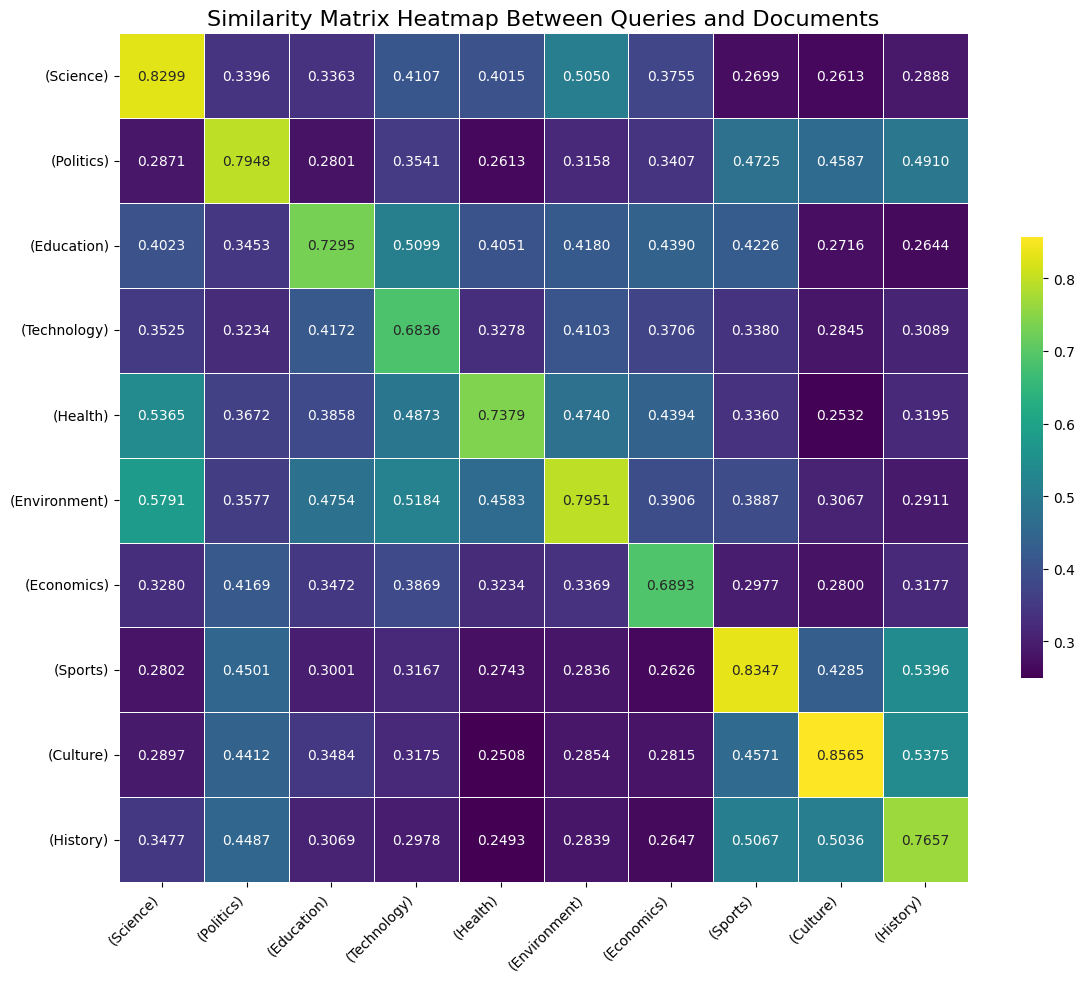

In [175]:
show_heatmap(query_embeddings_py,document_embeddings_py)

In [162]:
calculate_similarity_from_list(query_embeddings_py[0].tolist(),document_embeddings_py[0].tolist())

0.8299457064802569

In [44]:
fields = [
    "(Science)",
    "(Politics)",
    "(Education)",
    "(Technology)",
    "(Health)",
    "(Environment)",
    "(Economics)",
    "(Sports)",
    "(Culture)",
    "(History)"
]

In [164]:
def cosine_similarity(query_embeddings, document_embeddings):
    # Convert lists to NumPy arrays
    query_embeddings = np.array(query_embeddings)
    document_embeddings = np.array(document_embeddings)

    # Normalize the embeddings (L2 norm)
    query_norms = np.linalg.norm(query_embeddings, axis=1, keepdims=True)
    document_norms = np.linalg.norm(document_embeddings, axis=1, keepdims=True)

    query_embeddings_normalized = query_embeddings / query_norms
    document_embeddings_normalized = document_embeddings / document_norms

    # Compute cosine similarity using dot product
    similarity_scores = query_embeddings_normalized @ document_embeddings_normalized.T

    return similarity_scores

In [35]:
def calculate_similarity(query_list,document_list):
  query_embeddings = torch.stack(query_list)
  document_embeddings = torch.stack(document_list)
  similarity_scores = query_embeddings @ document_embeddings.T
  return similarity_scores

In [41]:
def calculate_similarity_from_list(query_embeddings,document_embeddings):
  query_embeddings = np.array(query_embeddings)
  document_embeddings = np.array(document_embeddings)
  similarity_scores = query_embeddings @ document_embeddings.T
  return similarity_scores

In [185]:
def show_heatmap(query_embeddings,document_embeddings):
  similarities = cosine_similarity(query_embeddings,document_embeddings)
  df = pd.DataFrame(similarities.tolist(), index=fields, columns=fields)
  # Set up the matplotlib figure
  plt.figure(figsize=(12, 10))

  # Generate a custom diverging colormap
  cmap = sns.diverging_palette(220, 20, as_cmap=True)

  # Draw the heatmap
  sns.heatmap(df, annot=True, fmt=".4f", cmap='viridis', linewidths=.5, square=True, cbar_kws={"shrink": .5})

  # Add title and adjust layout
  plt.title('Similarity Matrix Heatmap Between Queries and Documents', fontsize=16)
  plt.xticks(rotation=45, ha='right')
  plt.yticks(rotation=0)
  plt.tight_layout()

  # Display the heatmap
  plt.show()

In [ ]:
# Function to multithread
@time_it
def multithreaded_embedder(input):
  results=[]
  with ThreadPoolExecutor() as executor:
    print(f"Using {executor._max_workers} threads")
    results = list(executor.map(embed_batch, input))
    print('Finish multithreaded embedder')
    display_resource_usage()
    clear_gpu_memory()
  return results

In [ ]:
display_resource_usage()

CPU Usage: 61.90%
RAM Usage: 2795.65 MB / 12638.34 MB
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   9504 MiB |  11375 MiB | 306683 MiB | 297179 MiB |
|---------------------------------------------------------------------------|
| Active memory         |   9504 MiB |  11375 MiB | 306683 MiB | 297179 MiB |
|---------------------------------------------------------------------------|
| Requested memory      |   9503 MiB |  11373 MiB | 301687 MiB | 292183 MiB |
|---------

In [ ]:
multi_embeds = multithreaded_embedder(queries)

CPU Usage: 21.10%
RAM Usage: 2846.30 MB / 12638.81 MB
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   9514 MiB |   9715 MiB |  36069 MiB |  26554 MiB |
|---------------------------------------------------------------------------|
| Active memory         |   9514 MiB |   9715 MiB |  36069 MiB |  26554 MiB |
|---------------------------------------------------------------------------|
| Requested memory      |   9514 MiB |   9712 MiB |  34889 MiB |  25374 MiB |
|---------

In [ ]:
@time_it
def batch_multithreaded_embedder(input,batch_size = 4):
  multithreaded_embeddings_list = []
  batches = []
  for i in range(0, len(input), batch_size):
    print(f"Batch: {i}")
    batches.append(''.join(input[i:i + batch_size]))
  multithreaded_embeddings = multithreaded_embedder(batches)
  multithreaded_embeddings_list.extend(multithreaded_embeddings)
  return multithreaded_embeddings_list

In [ ]:
!pip install PyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 14.6 MB/s eta 0:00:00


In [ ]:
from PyPDF2 import PdfReader
# Function to upload a file in Google Colab
def upload_file():
    uploaded = files.upload()
    for file_name in uploaded.keys():
        return file_name

# Function to extract text from PDF using PyPDF2
def extract_text_from_pdf(pdf_path):
    reader = PdfReader(pdf_path)
    text_chunks = []
    for page in reader.pages:
        text = page.extract_text()
        if text.strip():  # Avoid empty pages or whitespace
            text_chunks.append(text.strip())
    return text_chunks

In [ ]:
print('Upload pdf file.')
pdf_path = upload_file()  # Get the uploaded file path

# Extract text from the uploaded PDF
text = extract_text_from_pdf(pdf_path)

In [ ]:
print('Upload pdf file.')
pdf_path_large = upload_file()  # Get the uploaded file path

# Extract text from the uploaded PDF
text_large = extract_text_from_pdf(pdf_path_large)

Upload pdf file.


Saving test_large.pdf to test_large.pdf


In [ ]:
# Configure batch size
batch_size = 20
embeddings_list = batch_embedder(text_large,batch_size)

CPU Usage: 55.00%
RAM Usage: 3156.02 MB / 12631.46 MB
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 2            |        cudaMalloc retries: 3         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  11798 MiB |  14091 MiB |   2046 GiB |   2035 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  11798 MiB |  14091 MiB |   2046 GiB |   2035 GiB |
|---------------------------------------------------------------------------|
| Requested memory      |  11788 MiB |  14083 MiB |   2011 GiB |   1999 GiB |
|---------

In [ ]:
embeddings_list = batch_multithreaded_embedder(text_large)

Batch: 0
Batch: 4
Batch: 8
Batch: 12
Batch: 16
Batch: 20
Batch: 24
Batch: 28
Batch: 32
Batch: 36
Batch: 40
Batch: 44
Batch: 48
Batch: 52
Batch: 56
Batch: 60
Batch: 64
Batch: 68
Batch: 72
Batch: 76
Batch: 80
Batch: 84
Batch: 88
Batch: 92
Batch: 96
Using 6 threads
CPU Usage: 100.00%
RAM Usage: 3402.17 MB / 12627.68 MB
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 2            |        cudaMalloc retries: 3         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  10215 MiB |  14091 MiB |   2826 GiB |   2817 GiB |
|---------------------------------------------------------

In [ ]:
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) and obj.is_cuda:
            del obj
    except ReferenceError:
        # Skip objects that no longer exist
        pass

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:1021: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(obj, torch.Tensor)


In [ ]:
display_resource_usage()

CPU Usage: 5.00%
RAM Usage: 3346.23 MB / 12627.68 MB
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 2            |        cudaMalloc retries: 3         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   9552 MiB |  14091 MiB |   2910 GiB |   2901 GiB |
|---------------------------------------------------------------------------|
| Active memory         |   9552 MiB |  14091 MiB |   2910 GiB |   2901 GiB |
|---------------------------------------------------------------------------|
| Requested memory      |   9550 MiB |  14083 MiB |   2873 GiB |   2864 GiB |
|----------

In [5]:
!git clone https://github.com/ggerganov/llama.cpp.git
%cd llama.cpp

Cloning into 'llama.cpp'...
remote: Enumerating objects: 40388, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 40388 (delta 52), reused 17 (delta 17), pack-reused 40303 (from 4)
Receiving objects: 100% (40388/40388), 71.20 MiB | 21.31 MiB/s, done.
Resolving deltas: 100% (29287/29287), done.
/content/llama.cpp


In [6]:
!apt-get update
!apt-get install -y build-essential cmake git

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,197 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,564 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://security.ubuntu.com/ubuntu jammy-sec

In [48]:
!git clone https://huggingface.co/Alibaba-NLP/gte-Qwen2-1.5B-instruct

Cloning into 'gte-Qwen2-1.5B-instruct'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 77 (delta 28), reused 0 (delta 0), pack-reused 4 (from 1)
Unpacking objects: 100% (77/77), 3.66 MiB | 2.61 MiB/s, done.
Filtering content: 100% (2/2), 2.61 GiB | 12.57 MiB/s, done.
Encountered 1 file(s) that may not have been copied correctly on Windows:
	model-00001-of-00002.safetensors

See: `git lfs help smudge` for more details.


In [7]:
!git clone https://huggingface.co/Snowflake/snowflake-arctic-embed-s

Cloning into 'snowflake-arctic-embed-s'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 102 (delta 2), reused 0 (delta 0), pack-reused 96 (from 1)
Receiving objects: 100% (102/102), 402.44 KiB | 14.37 MiB/s, done.
Resolving deltas: 100% (45/45), done.
Filtering content: 100% (8/8), 530.54 MiB | 51.81 MiB/s, done.


In [8]:
!mkdir build
%cd build

/content/llama.cpp/build


In [9]:
#!cmake .. -DGGML_CUDA=ON -DLLAMA_CUBLAS=OFF
!cmake ..

-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found Git: /usr/bin/git (found version "2.34.1")
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD - Success
-- Found Threads: TRUE
-- Warning: ccache not found - consider installing it for faster compilation or disable this warning with GGML_CCACHE=OFF
-- CMAKE_SYSTEM_PROCESSOR: x86_64
-- Including CPU backend
-- Found OpenMP_C: -fopenmp (found version "4.5")
-- Found OpenMP_CXX: -fopenmp (found version "4.5")
-- Found OpenMP: TRUE (found version "4.5

In [10]:
!make -j$(nproc)  # On Linux or WSL

[  0%] Generating build details from Git
[  1%] Building C object ggml/src/CMakeFiles/ggml-base.dir/ggml.c.o
-- Found Git: /usr/bin/git (found version "2.34.1")
[  2%] Building CXX object common/CMakeFiles/build_info.dir/build-info.cpp.o
[  2%] Built target build_info
[  3%] Building C object examples/gguf-hash/CMakeFiles/sha256.dir/deps/sha256/sha256.c.o
[  3%] Built target sha256
[  4%] Building C object examples/gguf-hash/CMakeFiles/xxhash.dir/deps/xxhash/xxhash.c.o
[  4%] Built target xxhash
[  4%] Building C object examples/gguf-hash/CMakeFiles/sha1.dir/deps/sha1/sha1.c.o
[  4%] Built target sha1
[  5%] Building C object ggml/src/CMakeFiles/ggml-base.dir/ggml-alloc.c.o
[  5%] Building CXX object ggml/src/CMakeFiles/ggml-base.dir/ggml-backend.cpp.o
[  6%] Building CXX object ggml/src/CMakeFiles/ggml-base.dir/ggml-opt.cpp.o
[  6%] Building CXX object ggml/src/CMakeFiles/ggml-base.dir/ggml-threading.cpp.o
[  7%] Building C object ggml/src/CMakeFiles/ggml-base.dir/ggml-quants.c.o
[  7

In [11]:
%cd ..

/content/llama.cpp


In [52]:
!python convert_hf_to_gguf.py gte-Qwen2-1.5B-instruct/ --outfile model-Alibaba-f16.gguf

INFO:hf-to-gguf:Loading model: gte-Qwen2-1.5B-instruct
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Exporting model...
INFO:hf-to-gguf:gguf: loading model weight map from 'model.safetensors.index.json'
INFO:hf-to-gguf:gguf: loading model part 'model-00001-of-00002.safetensors'
INFO:hf-to-gguf:token_embd.weight,         torch.float32 --> F16, shape = {1536, 151646}
INFO:hf-to-gguf:blk.0.attn_norm.weight,    torch.float32 --> F32, shape = {1536}
INFO:hf-to-gguf:blk.0.ffn_down.weight,     torch.float32 --> F16, shape = {8960, 1536}
INFO:hf-to-gguf:blk.0.ffn_gate.weight,     torch.float32 --> F16, shape = {1536, 8960}
INFO:hf-to-gguf:blk.0.ffn_up.weight,       torch.float32 --> F16, shape = {1536, 8960}
INFO:hf-to-gguf:blk.0.ffn_norm.weight,     torch.float32 --> F32, shape = {1536}
INFO:hf-to-gguf:blk.0.attn_k.bias,         torch.float32 --> F32, shape = {256}
INFO:hf-to-gguf:blk.0.attn_k.weight,       torch.float32 --> F16, shape = {1536, 256}
INFO

In [12]:
!python convert_hf_to_gguf.py snowflake-arctic-embed-s/ --outfile model-f16.gguf

INFO:hf-to-gguf:Loading model: snowflake-arctic-embed-s
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Exporting model...
INFO:hf-to-gguf:gguf: loading model part 'model.safetensors'
INFO:hf-to-gguf:token_embd_norm.bias,            torch.float32 --> F32, shape = {384}
INFO:hf-to-gguf:token_embd_norm.weight,          torch.float32 --> F32, shape = {384}
INFO:hf-to-gguf:position_embd.weight,            torch.float32 --> F32, shape = {384, 512}
INFO:hf-to-gguf:token_types.weight,              torch.float32 --> F32, shape = {384, 2}
INFO:hf-to-gguf:token_embd.weight,               torch.float32 --> F16, shape = {384, 30522}
INFO:hf-to-gguf:blk.0.attn_output_norm.bias,     torch.float32 --> F32, shape = {384}
INFO:hf-to-gguf:blk.0.attn_output_norm.weight,   torch.float32 --> F32, shape = {384}
INFO:hf-to-gguf:blk.0.attn_output.bias,          torch.float32 --> F32, shape = {384}
INFO:hf-to-gguf:blk.0.attn_output.weight,        torch.float32 --> F16, shap

In [53]:
%cd build/bin

/content/llama.cpp/build/bin


In [54]:
!./llama-quantize /content/llama.cpp/model-Alibaba-f16.gguf ../../model-Alibaba-q8_0.gguf q8_0

main: build = 4404 (0827b2c1)
main: built with cc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0 for x86_64-linux-gnu
main: quantizing '/content/llama.cpp/model-Alibaba-f16.gguf' to '../../model-Alibaba-q8_0.gguf' as Q8_0
llama_model_loader: loaded meta data with 28 key-value pairs and 339 tensors from /content/llama.cpp/model-Alibaba-f16.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = qwen2
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name str              = Gte Qwen2 1.5B Instruct
llama_model_loader: - kv   3:                           general.finetune str              = instruct
llama_model_loader: - kv   4:                           general.basename str              = gte-Qwen2
llama_model_loader: - k

In [14]:
!./llama-quantize /content/llama.cpp/model-f16.gguf ../../model-q8_0.gguf q8_0

main: build = 4404 (0827b2c1)
main: built with cc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0 for x86_64-linux-gnu
main: quantizing '/content/llama.cpp/model-f16.gguf' to '../../model-q8_0.gguf' as Q8_0
llama_model_loader: loaded meta data with 26 key-value pairs and 197 tensors from /content/llama.cpp/model-f16.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = bert
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name str              = Snowflake Arctic Embed S
llama_model_loader: - kv   3:                         general.size_label str              = 33M
llama_model_loader: - kv   4:                            general.license str              = apache-2.0
llama_model_loader: - kv   5:                      

In [ ]:
!./llama-embedding -m ../../model-f16.gguf -e -p "Hello world" --verbose-prompt -ngl 0

In [ ]:
!./llama-embedding -m ../../model-q8_0.gguf -e -p "Hello world" --verbose-prompt -ngl 0

In [20]:
!./llama-embedding --help

----- common params -----

-h,    --help, --usage                  print usage and exit
--version                               show version and build info
--verbose-prompt                        print a verbose prompt before generation (default: false)
-t,    --threads N                      number of threads to use during generation (default: -1)
                                        (env: LLAMA_ARG_THREADS)
-tb,   --threads-batch N                number of threads to use during batch and prompt processing (default:
                                        same as --threads)
-C,    --cpu-mask M                     CPU affinity mask: arbitrarily long hex. Complements cpu-range
                                        (default: "")
-Cr,   --cpu-range lo-hi                range of CPUs for affinity. Complements --cpu-mask
--cpu-strict <0|1>                      use strict CPU placement (default: 0)
--prio N                                set process/thread priority : 0-normal, 1-medium,

In [90]:
!./llama-embedding -m ../../model-Alibaba-f16.gguf -e -p "Hello"  -c 5

build: 4404 (0827b2c1) with cc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0 for x86_64-linux-gnu
llama_model_loader: loaded meta data with 28 key-value pairs and 339 tensors from ../../model-Alibaba-f16.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = qwen2
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name str              = Gte Qwen2 1.5B Instruct
llama_model_loader: - kv   3:                           general.finetune str              = instruct
llama_model_loader: - kv   4:                           general.basename str              = gte-Qwen2
llama_model_loader: - kv   5:                         general.size_label str              = 1.5B
llama_model_loader: - kv   6:                            gener

In [121]:
result = subprocess.run(
                        ["./llama-embedding", "-m", "../../model-Alibaba-f16.gguf", "-e", "-p", 'hello', "-c", "512"],
                        cwd="/content/llama.cpp/build/bin",
                        check=True,
                        #capture_output=True,
                        stdout=subprocess.PIPE, stderr=subprocess.PIPE
                    )

In [122]:
output = result.stdout.decode('utf-8')

In [123]:
output

'\nembedding 0:  0.011481  0.045122  0.004584  ... -0.009514 -0.009221  0.030460 \nembedding 1: -0.034042  0.056464  0.035032  ... -0.008997 -0.032792 -0.010037 \n\n'

In [120]:
!./llama-embedding -m ../../model-Alibaba-f16.gguf -e -p "Hello" -c 32 -b 256 > embeddings_output.txt

build: 4404 (0827b2c1) with cc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0 for x86_64-linux-gnu
llama_model_loader: loaded meta data with 28 key-value pairs and 339 tensors from ../../model-Alibaba-f16.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = qwen2
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name str              = Gte Qwen2 1.5B Instruct
llama_model_loader: - kv   3:                           general.finetune str              = instruct
llama_model_loader: - kv   4:                           general.basename str              = gte-Qwen2
llama_model_loader: - kv   5:                         general.size_label str              = 1.5B
llama_model_loader: - kv   6:                            gener

In [118]:

embedding_start = "embedding"
embeddings = []
for embeds in output.strip().split('\n'):
  embedding_line = embeds.split(':')[1].strip()
  print(embedding_line.split())
  embedding = list(map(float, embedding_line.split()))
  embeddings.append(embedding)

# if embedding_start in output:
#     embedding_line = output.split(':')[1].strip()
#     embedding = list(map(float, embedding_line.split()))
#     embeddings.append(embedding)


['0.011481', '0.045122', '0.004584', '...', '-0.009514', '-0.009221', '0.030460']


ValueError: could not convert string to float: '...'

In [109]:
for e in embedding_line.split():
  try:
    float(e)
  except:
    print(e)

...


In [64]:
import subprocess
@time_it
def get_embedding(input):
    try:
      embeddings = []
      for text in input:
          print(f"Processing text: {text}")
          # Run the command and capture output
          result = subprocess.run(
                        ["./llama-embedding", "-m", "../../model-Alibaba-f16.gguf", "-e", "-p", text, "-c", "32"],
                        cwd="/content/llama.cpp/build/bin",
                        check=True,
                        capture_output=True
                    )
          # Check for errors
          if result.returncode != 0:
              print(f"Error: {result.stderr}")
              return None
          # Parse the embedding from the output
          output = result.stdout.decode('utf-8')
          embedding_start = "embedding 0:"
          if embedding_start in output:
              embedding_line = output.split(embedding_start)[1].strip()
              embedding = list(map(float, embedding_line.split()))
              embeddings.append(embedding)
          else:
              print("Embedding not found in the output.")
              return None
      return embeddings

    except Exception as e:
        print(f"An exception occurred: {e}")
        return None

In [65]:
# Extract the embedding
query_embeddings = get_embedding(['Hello'])

Processing text: Hello
An exception occurred: could not convert string to float: '...'
Function 'get_embedding' took 2.715884 seconds to execute.


In [37]:
document_embeddings = get_embedding(documents)

Processing text: जलवायु परिवर्तनका मुख्य कारणहरूमा हरितगृह ग्याँसको उत्सर्जन, वनहरूको कटान, औद्योगिक गतिविधिहरू, र कृषि क्षेत्रमा प्रदूषण समावेश छन्। यी कारणहरूले पृथ्वीको तापक्रम वृद्धिमा योगदान पुर्‍याउँछन्, जसले मौसमका पैटर्नहरू परिवर्तन गराउँछ र प्राकृतिक प्रकोपहरू बढाउँछ। जलवायु परिवर्तनलाई रोक्नको लागि हरितगृह ग्याँसको उत्सर्जन घटाउने, नवीकरणीय ऊर्जा स्रोतहरूको प्रयोग, वन संरक्षण, र दिगो कृषि अभ्यासहरू अपनाउनु महत्वपूर्ण छ।
Processing text: नेपालको वर्तमान राजनीतिक स्थिति अस्थिर रहेको छ। विभिन्न राजनीतिक दलहरू बीचको मतभेद, सरकारको कार्यसम्पादनमा असन्तुष्टि, र समाजमा विभाजनकारी मुद्दाहरूले राजनीतिक स्थायित्वमा बाधा पुर्‍याएका छन्। प्रधानमन्त्रीको नेतृत्वमा सरकारले आर्थिक विकास, सामाजिक न्याय, र राष्ट्रिय एकता कायम गर्न विभिन्न नीतिहरू कार्यान्वयन गर्दैछ। राजनीतिक स्थिरता कायम राख्नका लागि संवाद र सहकार्य आवश्यक छ।
Processing text: शैक्षिक प्रणाली सुधार गर्नका लागि गुणस्तरीय शिक्षण सामग्रीको विकास, शिक्षकहरूको तालिम, पाठ्यक्रमको अद्यावधिक, र प्रविधिको समावेशीकरण आवश्यक छ। साथै, विद

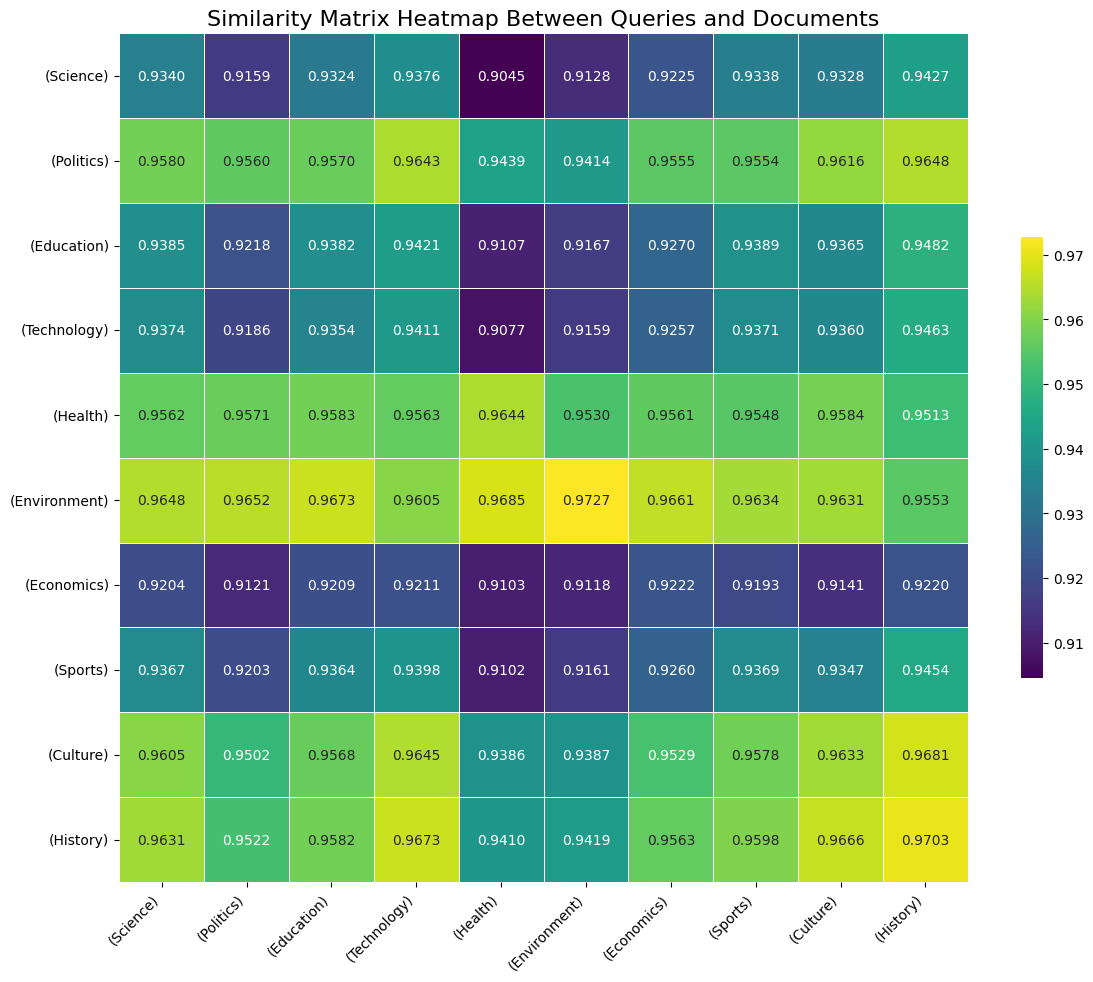

In [45]:
show_heatmap(query_embeddings,document_embeddings)

In [36]:
ls /content/llama.cpp/build/bin/

llama-batched*                  llama-lookup-merge*        test-arg-parser*
llama-batched-bench*            llama-lookup-stats*        test-autorelease*
llama-bench*                    llama-minicpmv-cli*        test-backend-ops*
llama-cli*                      llama-parallel*            test-barrier*
llama-convert-llama2c-to-ggml*  llama-passkey*             test-c*
llama-cvector-generator*        llama-perplexity*          test-chat-template*
llama-embedding*                llama-q8dot*               test-gguf*
llama-eval-callback*            llama-quantize*            test-grammar-integration*
llama-export-lora*              llama-quantize-stats*      test-grammar-parser*
llama-gbnf-validator*           llama-qwen2vl-cli*         test-json-schema-to-grammar*
llama-gen-docs*                 llama-retrieval*           test-llama-grammar*
llama-gguf*                     llama-run*                 test-log*
llama-gguf-hash*                llama-save-load-state*     test-model-load-cance

In [1]:
!pip install llama-cpp-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 MB 5.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.7 MB/s eta 0:00:00
  Created wheel for llama-cpp-python: filename=llama_cpp_python-0.3.5-cp310-cp310-linux_x86_64.whl size=3471479 sha256=7a53b255311dc616eda62d003d06b89345e2efb1e5c32ba9a466e61c9b6d6369
  Stored in directory: /root/.cache/pip/wheels/7e/ae/c3/34a10eba5fc4e75df17818312b6a1ee29eb90f13a12c524714
Successfully built llama-cpp-python


In [124]:
from llama_cpp import Llama

llm = Llama(
      model_path="/content/llama.cpp/model-Alibaba-f16.gguf",
      # n_gpu_layers=-1, # Uncomment to use GPU acceleration
      # seed=1337, # Uncomment to set a specific seed
      # n_ctx=2048, # Uncomment to increase the context window
)
output = llm(
      "Q: Name the planets in the solar system? A: ", # Prompt
      max_tokens=32, # Generate up to 32 tokens, set to None to generate up to the end of the context window
      stop=["Q:", "\n"], # Stop generating just before the model would generate a new question
      echo=True # Echo the prompt back in the output
) # Generate a completion, can also call create_completion
print(output)

llama_model_loader: loaded meta data with 28 key-value pairs and 339 tensors from /content/llama.cpp/model-Alibaba-f16.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = qwen2
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name str              = Gte Qwen2 1.5B Instruct
llama_model_loader: - kv   3:                           general.finetune str              = instruct
llama_model_loader: - kv   4:                           general.basename str              = gte-Qwen2
llama_model_loader: - kv   5:                         general.size_label str              = 1.5B
llama_model_loader: - kv   6:                            general.license str              = apache-2.0
llama_model_loader: - kv   7:       

{'id': 'cmpl-4213f507-a6c8-4e1d-b8b1-c188394207dc', 'object': 'text_completion', 'created': 1735722923, 'model': '/content/llama.cpp/model-Alibaba-f16.gguf', 'choices': [{'text': 'Q: Name the planets in the solar system? A:  planets solar system solar system solar system solar system solar system solar system solar system solar system solar system solar system solar system solar system solar system solar system solar system solar', 'index': 0, 'logprobs': None, 'finish_reason': 'length'}], 'usage': {'prompt_tokens': 14, 'completion_tokens': 32, 'total_tokens': 46}}


In [212]:
import llama_cpp
llm = Llama(model_path="/content/llama.cpp/model-Alibaba-f16.gguf", embedding=True,pooling_type=llama_cpp.LLAMA_POOLING_TYPE_MEAN)

# embeddings = llm.create_embedding("Hello, world!")

# # or create multiple embeddings at once

# embeddings = llm.create_embedding(["Hello, world!", "Goodbye, world!"])

llama_model_loader: loaded meta data with 28 key-value pairs and 339 tensors from /content/llama.cpp/model-Alibaba-f16.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = qwen2
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name str              = Gte Qwen2 1.5B Instruct
llama_model_loader: - kv   3:                           general.finetune str              = instruct
llama_model_loader: - kv   4:                           general.basename str              = gte-Qwen2
llama_model_loader: - kv   5:                         general.size_label str              = 1.5B
llama_model_loader: - kv   6:                            general.license str              = apache-2.0
llama_model_loader: - kv   7:       

In [199]:
@time_it
def embed_query_llamacpp(input):
  query_embeddings = llm.create_embedding(input)
  display_resource_usage()
  embeddings = []
  for embedding in query_embeddings['data']:
    embeddings_array = np.array(embedding['embedding'])

    # Calculate the average of all embeddings
    avg_embedding = np.mean(embeddings_array, axis=0)
    embeddings.append(avg_embedding)
  return embeddings

In [207]:
@time_it
def embed_query_llamacpp_batch(input):
  query_embeddings = []
  display_resource_usage()
  for text in input:
    #query_embeddings.append(embed_query_llamacpp(text))
    query_embeddings.append(llm.create_embedding(text)['data'][0]['embedding'])
  return query_embeddings

In [213]:
query_embeddings_llama = embed_query_llamacpp_batch(queries)

CPU Usage: 0.00%
RAM Usage: 7982.67 MB / 12639.57 MB


llama_perf_context_print:        load time =    6411.31 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    40 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    6411.46 ms /    41 tokens
llama_perf_context_print:        load time =    6411.31 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    39 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    4720.96 ms /    40 tokens
llama_perf_context_print:        load time =    6411.31 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    48 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time = 

Function 'embed_query_llamacpp_batch' took 48.058488 seconds to execute.


In [209]:
@time_it
def embed_document_llamacpp_batch(input):
  document_embeddings = []
  display_resource_usage()
  for text in input:
    #document_embeddings.append(embed_query_llamacpp(text))
    document_embeddings.append(llm.create_embedding(text)['data'][0]['embedding'])
  return document_embeddings

In [214]:
document_embeddings_llama = embed_document_llamacpp_batch(documents)

CPU Usage: 5.00%
RAM Usage: 8021.15 MB / 12639.50 MB


llama_perf_context_print:        load time =    6411.31 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   409 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   33411.09 ms /   410 tokens
llama_perf_context_print:        load time =    6411.31 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   366 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   29674.34 ms /   367 tokens
llama_perf_context_print:        load time =    6411.31 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   423 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time = 

Function 'embed_document_llamacpp_batch' took 318.755109 seconds to execute.


In [179]:
len(query_embeddings[1][0])

1536

In [180]:
query_embeddingsv2 = []
for query_embedding in query_embeddings:
  query_embeddingsv2.append(query_embedding[0])

In [183]:
document_embeddingsv2 = []
for document_embedding in document_embeddings:
  document_embeddingsv2.append(document_embedding[0])

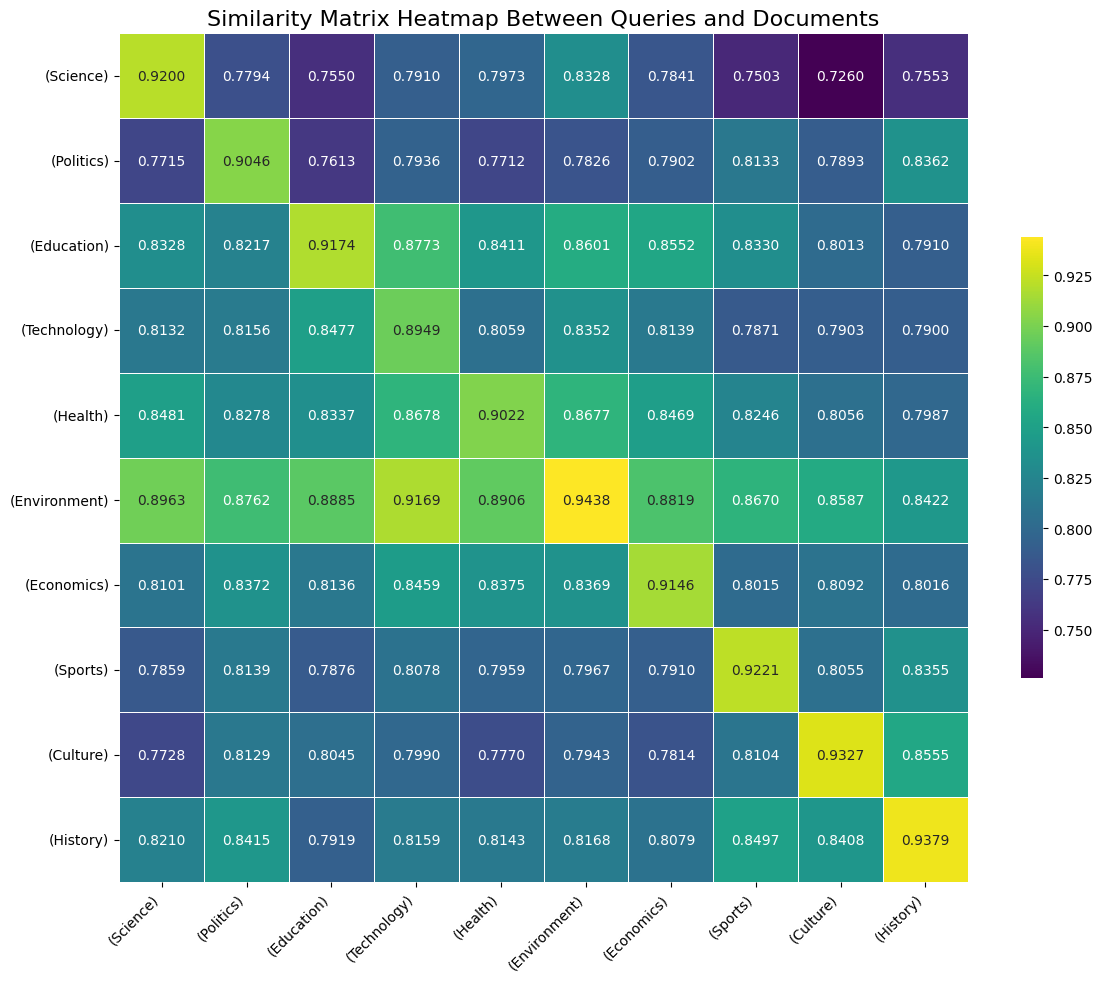

In [186]:
show_heatmap(query_embeddingsv2,document_embeddingsv2)

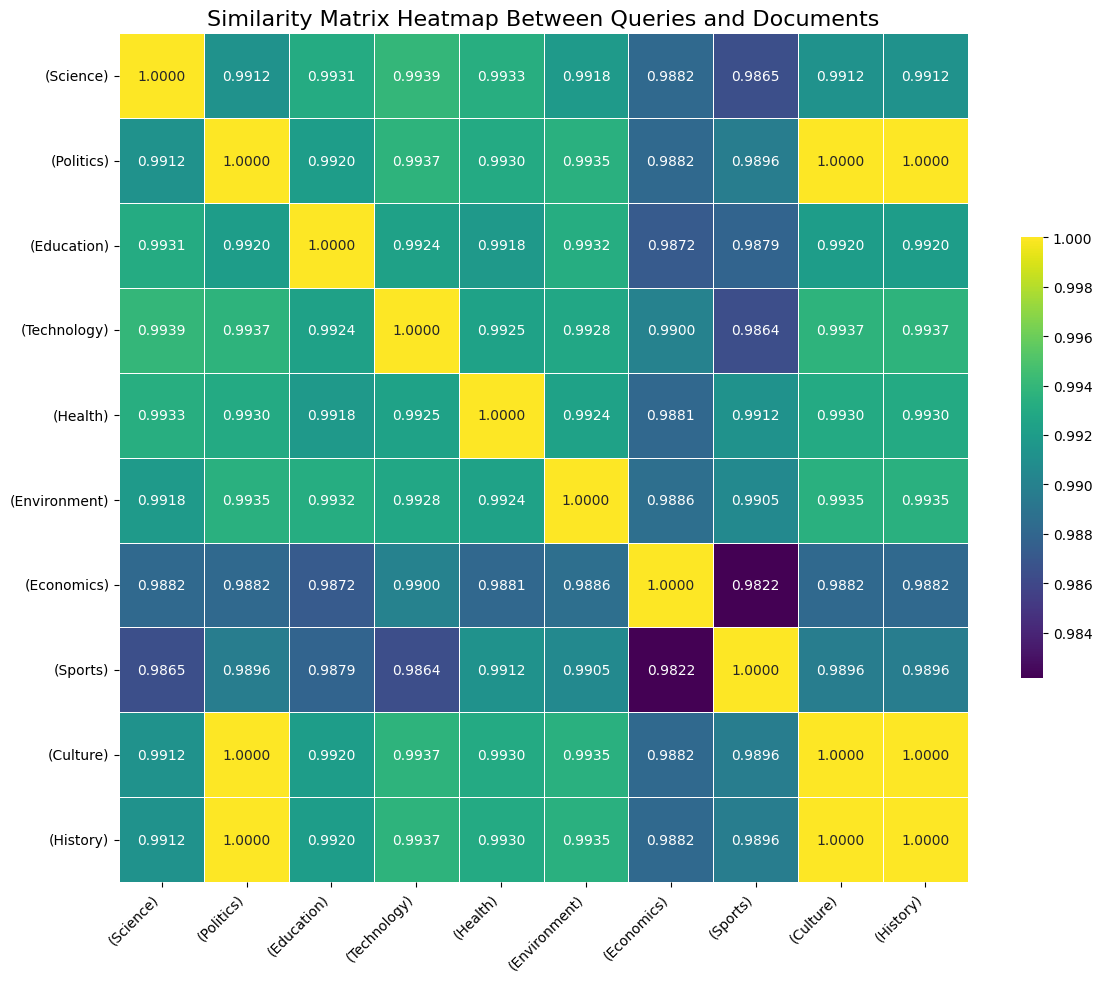

In [211]:
show_heatmap(query_embeddings_llama,document_embeddings_llama)

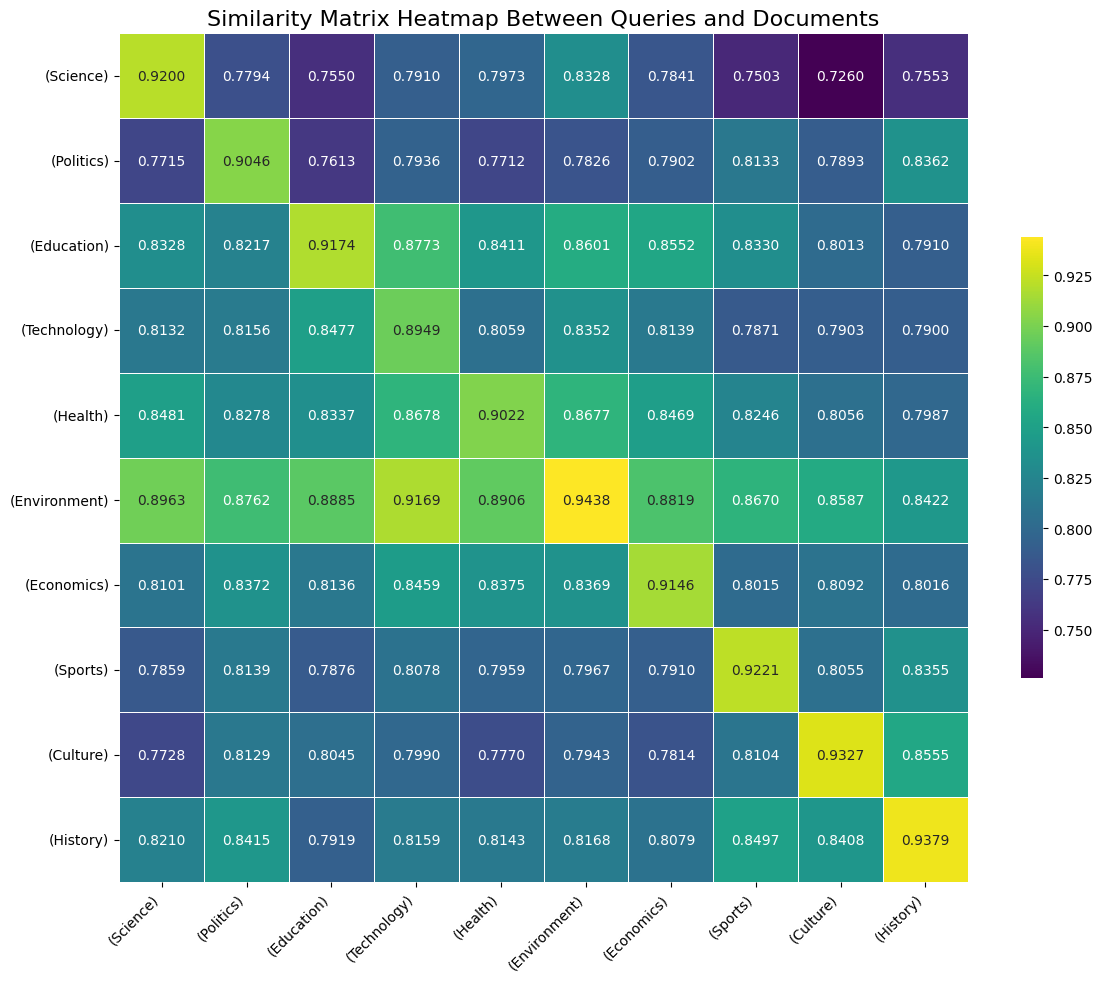

In [215]:
show_heatmap(query_embeddings_llama,document_embeddings_llama)

In [144]:
calculate_similarity_from_list(query_embeddings[0],document_embeddings[0])

6384.710897728176

In [146]:
document_embeddings1 = embed_query_llamacpp(documents[1])

llama_perf_context_print:        load time =    2093.90 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   366 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   46832.06 ms /   367 tokens


Function 'embed_query_llamacpp' took 46.882177 seconds to execute.


In [147]:
calculate_similarity_from_list(query_embeddings[0],document_embeddings1[0])

5336.701606349978

In [148]:
query_embeddings1 = embed_query_llamacpp(queries[1])

llama_perf_context_print:        load time =    2093.90 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    39 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    7154.85 ms /    40 tokens


Function 'embed_query_llamacpp' took 7.202094 seconds to execute.


In [149]:
calculate_similarity_from_list(query_embeddings1[0],document_embeddings1[0])

5504.139287452777

In [163]:
calculate_similarity_from_list(query_embeddings1[0],document_embeddings[0])

4758.082993416316